## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
#change matplotlib plot style
plt.style.use('ggplot')
import numpy as np
import torch
import torch.nn as nn

In [9]:
#gpu check
gpu = 'mps:0' if torch.backends.mps.is_available() else 'cpu'
gpu

'mps:0'

## Preparing Data

In [10]:
df = pd.read_csv('Amazon.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [12]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


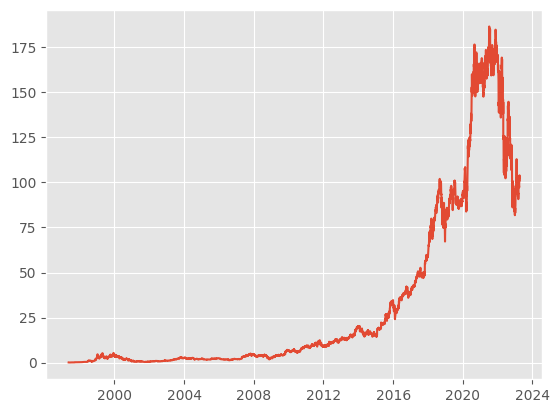

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])
plt.show()

In [14]:
#changing the data to a weekly basis

from copy import deepcopy as dc

def create_data(data, days):
  df_train = dc(df)
  df_train.set_index('Date', inplace=True)
  for i in range(1, days+1):
    df_train[f'Close(t-{i})'] = df_train['Close'].shift(i)
  df_train.dropna(inplace=True)
  return df_train

days = 7
df_train = create_data(df, days)
df_train.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


## Preprocessing and Splitting

In [15]:
from sklearn.preprocessing import MinMaxScaler  

scaler = MinMaxScaler(feature_range=(-1, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled, columns=df_train.columns, index=df_train.index)

In [16]:
df_train_scaled.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,-0.999911,-0.999955,-1.000000,-0.999983,-0.999872,-0.999832,-0.999821,-0.999698
1997-05-28,-0.999939,-0.999911,-0.999944,-1.000000,-0.999983,-0.999872,-0.999832,-0.999821
1997-05-29,-0.999953,-0.999939,-0.999899,-0.999944,-1.000000,-0.999983,-0.999872,-0.999832
1997-05-30,-0.999955,-0.999953,-0.999927,-0.999899,-0.999944,-1.000000,-0.999983,-0.999872
1997-06-02,-0.999950,-0.999955,-0.999941,-0.999927,-0.999899,-0.999944,-1.000000,-0.999983


In [17]:
X = df_train_scaled.drop('Close', axis=1).values
y = df_train_scaled['Close'].values

X.shape, y.shape

((6509, 7), (6509,))

In [18]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [19]:
split = int(0.9 * len(X))
split

5858

In [20]:
X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5858, 7), (651, 7), (5858,), (651,))

In [21]:
X_train = X_train.reshape(-1, 7, 1)
X_test = X_test.reshape(-1, 7, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5858, 7, 1), (651, 7, 1), (5858, 1), (651, 1))

In [22]:
X_train = torch.tensor(X_train).float() 
X_test = torch.tensor(X_test).float() 
y_train = torch.tensor(y_train).float() 
y_test = torch.tensor(y_test).float() 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5858, 7, 1]),
 torch.Size([651, 7, 1]),
 torch.Size([5858, 1]),
 torch.Size([651, 1]))

In [23]:
from torch.utils.data import DataLoader, Dataset 

class StockDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  
train_data = StockDataset(X_train, y_train)
test_data = StockDataset(X_test, y_test)

In [24]:
batch_size = 16

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## LSTM Model

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(gpu)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(gpu)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(gpu)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train_one_epoch(epoch):
    model.train(True)
    running_loss = 0.0
    print(f'Epoch: {epoch + 1}')
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(gpu), batch[1].to(gpu)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

/opt/homebrew/Caskroom/miniforge/base/envs/DL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(gpu), batch[1].to(gpu)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [28]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.798
Batch 200, Loss: 0.194
Batch 300, Loss: 0.056

Val Loss: 0.312
***************************************************

Epoch: 2
Batch 100, Loss: 0.016
Batch 200, Loss: 0.006
Batch 300, Loss: 0.004

Val Loss: 0.113
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.092
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.080
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.068
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.055
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.043
*****************

## Predictions

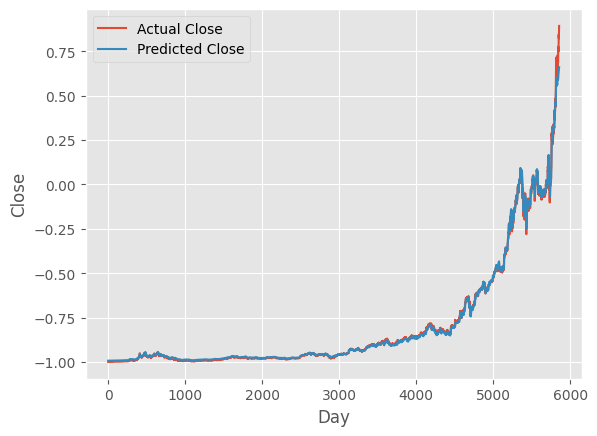

In [29]:
with torch.no_grad():
    predicted = model(X_train.to(gpu)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

### The scaled values are inverse transformed to get the actual values

In [30]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], days+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.72520195,   0.72635804,   0.72650255, ..., 153.74267592,
       154.22812239, 154.8778503 ])

In [31]:
dummies = np.zeros((X_train.shape[0], days+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.72548002e+02, 1.74955992e+02, 1.76572494e+02])

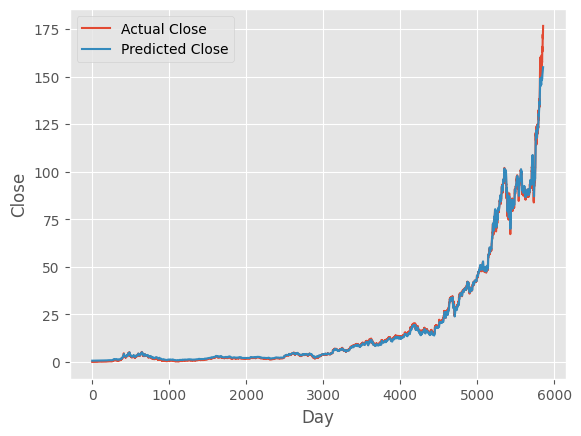

In [32]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

### Test Predictions

In [33]:
test_predictions = model(X_test.to(gpu)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], days+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([155.45155421, 154.28698291, 153.02471093, 150.91966074,
       151.09021731, 150.19992827, 149.09409522, 148.37544102,
       148.64428743, 147.87541003, 146.63987262, 145.28357387,
       144.64815256, 146.52094546, 145.83808002, 145.72007551,
       146.63169106, 148.05559327, 148.40577169, 148.61826986,
       149.53134164, 148.89371376, 149.41796705, 148.53992255,
       149.19105111, 149.46107585, 150.63994264, 152.76468526,
       153.72933087, 153.42429551, 153.04395315, 152.20457096,
       151.11554567, 150.6674887 , 150.09751429, 149.72208531,
       149.85248999, 149.95114668, 150.85605358, 149.968199  ,
       150.05358289, 148.1077229 , 146.69522041, 146.51096863,
       148.74198812, 150.69072165, 151.48425488, 150.0654995 ,
       148.10259276, 148.30170696, 148.10086974, 148.20600719,
       148.28228132, 148.37318442, 148.07342373, 148.06979983,
       147.85001497, 147.72966493, 147.9041233 , 148.77714325,
       149.3196105 , 149.27493431, 149.83151364, 149.92

In [34]:
dummies = np.zeros((X_test.shape[0], days+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([168.39999674, 164.73100188, 157.49200233, 163.43049557,
       158.75549155, 155.81100359, 155.14849755, 157.80650317,
       153.9050009 , 150.4364931 , 147.74550002, 148.02350066,
       156.44949298, 149.99299379, 150.98950412, 154.7564998 ,
       158.7025004 , 157.24400444, 157.43649336, 161.06300192,
       156.25000082, 159.96000907, 154.99800025, 159.78450022,
       159.52749817, 164.33250669, 172.14649963, 172.18150469,
       168.18550321, 166.93249662, 163.63549582, 160.36050519,
       160.85049265, 159.24699637, 158.82000468, 160.2200014 ,
       160.35200682, 164.31649929, 158.13900677, 160.55050963,
       151.80749309, 150.2240005 , 152.42050404, 162.05800044,
       166.1000065 , 165.56849431, 157.18699477, 151.75100589,
       156.86950922, 155.51400528, 156.44050549, 156.55299635,
       156.78300259, 155.27299395, 155.85099984, 154.96999843,
       154.91949732, 155.90300164, 159.25349382, 159.76699769,
       158.40199492, 161.00399689, 160.17649797, 159.33

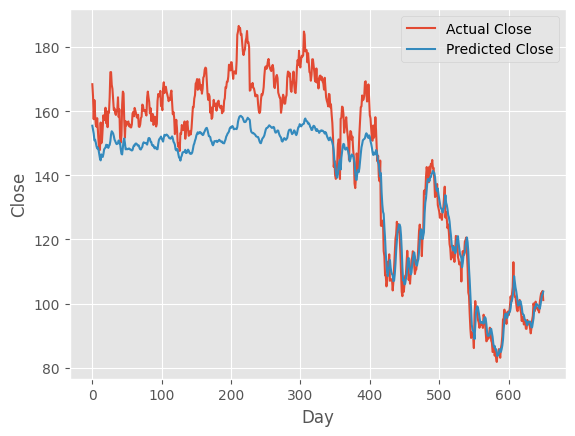

In [35]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()